In [ ]:
import cv2
import os

input_dir = "dataset/"
output_dir = "processed_dataset/"
image_size = (32, 32)

os.makedirs(output_dir, exist_ok=True)

for folder in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder)
    output_folder = os.path.join(output_dir, folder)
    os.makedirs(output_folder, exist_ok=True)

    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)

        # Debug file paths
        print(f"Processing: {img_path}")

        # Read the image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image was successfully loaded
        if img is None:
            print(f"Warning: Failed to load image {img_path}")
            continue

        # Resize the grayscale image
        img_resized = cv2.resize(img, image_size)

        # Save the preprocessed grayscale image
        output_file_path = os.path.join(output_folder, file)
        cv2.imwrite(output_file_path, img_resized)



Processing: dataset/SLOW/SLOW34.jpeg
Processing: dataset/SLOW/SLOW8.jpeg
Processing: dataset/SLOW/SLOW38.jpeg
Processing: dataset/SLOW/SLOW13.jpeg
Processing: dataset/SLOW/SLOW3.jpeg
Processing: dataset/SLOW/SLOW28.jpeg
Processing: dataset/SLOW/SLOW24.jpeg
Processing: dataset/SLOW/SLOW30.jpeg
Processing: dataset/SLOW/SLOW11.jpeg
Processing: dataset/SLOW/SLOW9.jpeg
Processing: dataset/SLOW/SLOW25.jpeg
Processing: dataset/SLOW/SLOW20.jpeg
Processing: dataset/SLOW/SLOW15.jpeg
Processing: dataset/SLOW/SLOW33.jpeg
Processing: dataset/SLOW/SLOW10.jpeg
Processing: dataset/SLOW/SLOW21.jpeg
Processing: dataset/SLOW/SLOW23.jpeg
Processing: dataset/SLOW/SLOW32.jpeg
Processing: dataset/SLOW/SLOW31.jpeg
Processing: dataset/SLOW/SLOW29.jpeg
Processing: dataset/SLOW/SLOW19.jpeg
Processing: dataset/SLOW/SLOW39.jpeg
Processing: dataset/SLOW/SLOW27.jpeg
Processing: dataset/SLOW/SLOW26.jpeg
Processing: dataset/SLOW/SLOW6.jpeg
Processing: dataset/SLOW/SLOW16.jpeg
Processing: dataset/SLOW/SLOW36.jpeg
Proce

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import pandas as pd
from sklearn.model_selection import train_test_split



In [ ]:
rm -rf processed_dataset/.ipynb_checkpoints


In [ ]:
# Dataset path
dataset_path = "processed_dataset/"
image_size = (32, 32)
batch_size = 32

# Define classes
classes = ['DISCO', 'GO', 'SLOW', 'STOP']

# Collect all file paths and labels
all_images = []
all_labels = []

for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_dir):
        all_images.append(os.path.join(class_dir, img_name))
        all_labels.append(class_name)

# Combine into a dataframe
data = pd.DataFrame({'filepath': all_images, 'label': all_labels})

# Shuffle the data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

VAL_SIZE = 0.15
# Split into training and validation sets
train_df, val_df = train_test_split(data, test_size=VAL_SIZE, stratify=data['label'], random_state=42)

# Create ImageDataGenerators
datagen_train = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1.0 / 255)

# Create data generators with grayscale conversion
train_data = datagen_train.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'  # Convert images to grayscale
)

val_data = datagen_val.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'  # Convert images to grayscale
)


# Verify the class indices
print(train_data.class_indices)

Found 148 validated image filenames belonging to 4 classes.
Found 27 validated image filenames belonging to 4 classes.
{'DISCO': 0, 'GO': 1, 'SLOW': 2, 'STOP': 3}


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [ ]:
class_counts = np.sum(train_data.labels, axis=0)
print("Class counts:", class_counts)

Class counts: 220


In [ ]:
pip install tensorflow-model-optimization


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 3.9 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [ ]:
from tensorflow.keras import layers, models
import tensorflow_model_optimization as tfmot


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),

    # layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),

    # layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(4, activation='softmax')
])

print(type(model))

# qat_model = tfmot.quantization.keras.quantize_model(base_model)


# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


<class 'keras.src.models.sequential.Sequential'>


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,180 (696.02 KB)

 Trainable params: 177,732 (694.27 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
class_weights = compute_class_weight(
    'balanced', classes=np.unique(train_data.classes), y=train_data.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

class_weights1 = compute_class_weight(
    'balanced', classes=np.unique(val_data.classes), y=val_data.classes
)
class_weights1 = dict(enumerate(class_weights1))
print("Class weights:", class_weights1)

Class weights: {0: 0.8222222222222222, 1: 1.3214285714285714, 2: 1.121212121212121, 3: 0.8809523809523809}
Class weights: {0: 0.84375, 1: 1.35, 2: 1.125, 3: 0.84375}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# lr_reduction = ReduceLROnPlateau(
#     monitor='val_loss',
#     patience=3,
#     factor=0.5,
#     verbose=1
# )

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [ ]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.2963 - loss: 1.5914 - val_accuracy: 0.2963 - val_loss: 1.3714
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.3332 - loss: 1.3304 - val_accuracy: 0.2963 - val_loss: 1.3685
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.5861 - loss: 0.9934 - val_accuracy: 0.2963 - val_loss: 1.3721
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.5607 - loss: 1.0756 - val_accuracy: 0.1852 - val_loss: 1.3855
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.5461 - loss: 0.9997 - val_accuracy: 0.1852 - val_loss: 1.3854
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.6191 - loss: 0.9090 - val_accuracy: 0.1852 - val_loss: 1.3901
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.6615 - loss: 0.7488 - val_accuracy: 0.2963 - val_loss: 1.4094
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.8135 - loss: 0.5646 - val_accuracy: 0.2593 - val_loss: 1.4

In [ ]:
# model.fit(
#     train_data,
#     validation_data=val_data,
#     epochs=30,
#     callbacks=[early_stop]
# )


class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 626ms/step - accuracy: 0.3054 - loss: 1.5222 - val_accuracy: 0.2963 - val_loss: 1.3776
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.5425 - loss: 1.0552 - val_accuracy: 0.2963 - val_loss: 1.3738
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.5693 - loss: 0.9553 - val_accuracy: 0.3333 - val_loss: 1.3730
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.6773 - loss: 0.7835 - val_accuracy: 0.2963 - val_loss: 1.3780
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7268 - loss: 0.6946 - val_accuracy: 0.1852 - val_loss: 1.3825
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.7966 - loss: 0.5315 - val_accuracy: 0.1852 - val_loss: 1.3927
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.8036 - loss: 0.5206 - val_accuracy: 0.1852 - val_loss: 1.4290
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8489 - loss: 0.3915 - val_accuracy: 0.1852 - val_loss: 1.4474


In [ ]:
import matplotlib.pyplot as plt


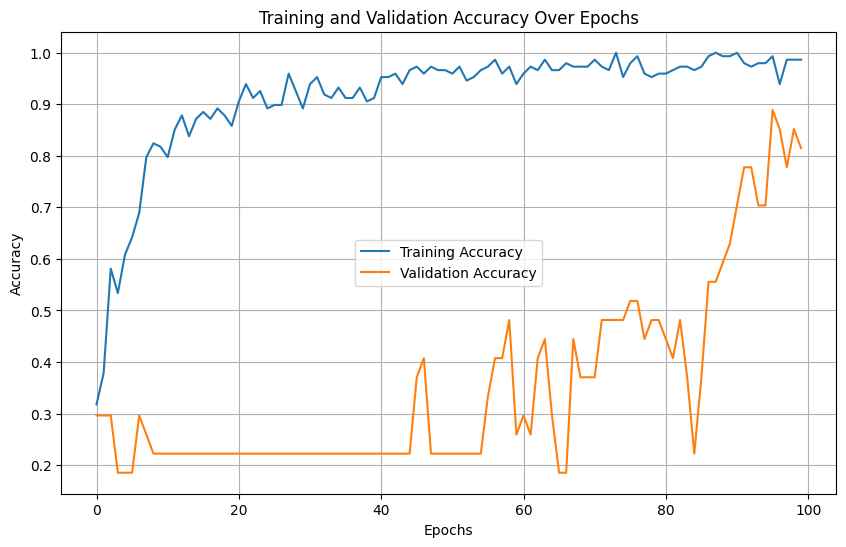

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the model
model.save("traffic_light_gesture_model_new5pm.keras")

In [ ]:
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0110
Validation Accuracy: 1.00


In [ ]:
# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model("traffic_light_gesture_model")
tflite_model = converter.convert()

# Save the TFLite model
with open("traffic_light_gesture_model.tflite", "wb") as f:
    f.write(tflite_model)



In [ ]:
model.save("traffic_light_gesture_model.keras")